In [1]:
! pip install tensorflow

In [2]:
# important libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest # Another popular anomaly detection algo
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import random

2025-07-29 04:36:51.986010: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-29 04:36:55.840235: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-29 04:36:57.306498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753763819.972611     564 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753763820.745911     564 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753763826.155537     564 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# synthetic data creation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random
import math # For haversine distance
from datetime import datetime, timedelta

# --- Constants for GPS simulation ---
AVG_WALKING_SPEED = 5 # km/h
AVG_CAR_SPEED_LOCAL = 40 # km/h
AVG_CAR_SPEED_HIGHWAY = 90 # km/h
MAX_PLAUSIBLE_SPEED = 200 # km/h (for instant check, if user moves faster than this without vehicle)
LOCATION_JUMP_THRESHOLD_KM = 500 # KM - for impossible jumps (e.g., Jalandhar to London in a second)

# --- Utility Function: Haversine distance for calculating distance between two lat/lon points ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371 # Earth radius in kilometers

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

# --- Behavioral Data Collection & Feature Extraction (Comprehensive Simulation) ---

def simulate_user_behavior_data(num_samples=100, user_id="user_A", is_fraudulent=False,
                                 start_lat=31.3260, start_lon=75.5762): # Jalandhar, Punjab, India
    """
    Simulates comprehensive behavioral data points for a user.
    Includes typing rhythm, detailed swipe/tap, device movement, app usage, and enhanced GPS/context.
    """
    data = []
    current_lat, current_lon = start_lat, start_lon
    prev_lat, prev_lon = start_lat, start_lon
    current_time = datetime(2025, 6, 18, 11, 0, 0) # Fixed start time for consistent time_of_day_anomaly simulation

    # Base profiles for normal vs. fraudulent behavior
    normal_profile = {
        'typing_speed_wpm': (60, 5), # mean, std
        'key_press_duration_ms': (80, 15),
        'time_between_keys_ms': (150, 30),
        'swipe_pressure_norm': (0.7, 0.1),
        'tap_duration_ms': (100, 20),
        'tap_count_per_min': (30, 8),
        'swipe_direction_angle_degrees': (180, 90), # Averages around 180 (downward swipe) with variance
        'device_angle_x_deg': (5, 2), # held mostly upright
        'accel_std_xyz': (0.05, 0.02), # low movement
        'gyro_z_avg_dps': (0.1, 0.05), # low rotation
        'nav_flow_speed_spm': (2.5, 0.5), # screens per minute
        'screen_time_seconds': (45, 15), # seconds on a screen
        'transaction_amount': (500, 100),
        'gps_speed_kmh_base': (AVG_WALKING_SPEED, 1), # Base for typical movement
        'ip_segment_base': '192.168.', # Local/stable IP segment
        'network_type_dist': ['WiFi'] * 8 + ['MobileData'] * 2 # Mostly WiFi
    }

    fraud_profile = {
        'typing_speed_wpm': (90, 10), # faster, less natural
        'key_press_duration_ms': (60, 10), # shorter, more uniform
        'time_between_keys_ms': (100, 20), # faster
        'swipe_pressure_norm': (0.9, 0.15), # harder or more erratic
        'tap_duration_ms': (70, 15), # quicker taps
        'tap_count_per_min': (60, 15), # faster tapping
        'swipe_direction_angle_degrees': (90, 120), # More random directions or specific to bot
        'device_angle_x_deg': (45, 15), # device held differently (e.g., on a desk, or remote)
        'accel_std_xyz_static': (0.005, 0.001), # very static (remote access)
        'accel_std_xyz_erratic': (0.5, 0.2), # very erratic (attacker fidgeting, or automated)
        'gyro_z_avg_dps': (1.0, 0.5), # more rotation (attacker adjusting)
        'nav_flow_speed_spm': (6.0, 1.0), # rapid navigation
        'screen_time_seconds': (15, 5), # very short screen times
        'transaction_amount': (5000, 2000), # larger, unusual transactions
        'gps_speed_kmh_base': (AVG_CAR_SPEED_HIGHWAY * 2, 50), # Implausible speed for non-travel
        'ip_segment_base': '104.23.', # VPN/proxy IP segment
        'network_type_dist': ['MobileData'] * 7 + ['VPN'] * 2 + ['Proxy'] * 1 # More mobile data/unstable connection
    }

    profile = fraud_profile if is_fraudulent else normal_profile

    for i in range(num_samples):
        # --- Timestamps ---
        # Simulate time passing, usually 1-5 seconds between data points
        current_time = current_time + timedelta(seconds=random.uniform(1, 5))
        timestamp = current_time

        # --- Typing Features ---
        typing_speed = max(1, random.gauss(*profile['typing_speed_wpm']))
        key_press_duration = max(1, random.gauss(*profile['key_press_duration_ms']))
        time_between_keys = max(1, random.gauss(*profile['time_between_keys_ms']))

        # --- Swipe/Tap Features ---
        swipe_pressure = max(0.01, min(1.0, random.gauss(*profile['swipe_pressure_norm']))) # Normalize 0-1
        tap_duration = max(1, random.gauss(*profile['tap_duration_ms']))
        tap_count_per_min = max(0, random.gauss(*profile['tap_count_per_min']))
        swipe_direction_angle = random.uniform(0, 360) # direction 0-360 degrees, can be more targeted for normal

        # --- Device Orientation and Movement (Accelerometer/Gyroscope) ---
        device_angle_x = max(0, min(90, random.gauss(*profile['device_angle_x_deg']))) # Angle between 0 and 90
        accel_x_std = random.gauss(*profile['accel_std_xyz']) if not is_fraudulent else (random.gauss(*profile['accel_std_xyz_static']) if random.random() < 0.5 else random.gauss(*profile['accel_std_xyz_erratic']))
        accel_y_std = random.gauss(*profile['accel_std_xyz']) if not is_fraudulent else (random.gauss(*profile['accel_std_xyz_static']) if random.random() < 0.5 else random.gauss(*profile['accel_std_xyz_erratic']))
        accel_z_std = random.gauss(*profile['accel_std_xyz']) if not is_fraudulent else (random.gauss(*profile['accel_std_xyz_static']) if random.random() < 0.5 else random.gauss(*profile['accel_std_xyz_erratic']))
        gyro_z_avg = random.gauss(*profile['gyro_z_avg_dps'])

        # --- App Usage Patterns ---
        nav_flow_speed = max(0.1, random.gauss(*profile['nav_flow_speed_spm']))
        screen_time_seconds = max(1, random.gauss(*profile['screen_time_seconds']))

        # --- Transaction Data ---
        transaction_amount = max(1, random.gauss(*profile['transaction_amount']))

        # --- GPS and Location ---
        simulated_speed_mps = random.gauss(*profile['gps_speed_kmh_base']) / 3.6 # Convert to m/s for movement calc
        simulated_bearing = random.uniform(0, 360) # degrees

        # Simulate normal movement patterns (e.g., travel)
        if not is_fraudulent and i % 50 == 0 and random.random() < 0.6: # Simulate occasional "travel"
            simulated_speed_mps = random.gauss(AVG_CAR_SPEED_LOCAL / 3.6, 2) # m/s
            simulated_bearing = random.uniform(0, 360)

        delta_lat = (simulated_speed_mps / 111139) * math.cos(math.radians(simulated_bearing)) # rough conversion
        delta_lon = (simulated_speed_mps / (111139 * math.cos(math.radians(current_lat)))) * math.sin(math.radians(simulated_bearing))

        current_lat += delta_lat
        current_lon += delta_lon

        dist_moved_km = haversine_distance(prev_lat, prev_lon, current_lat, current_lon)
        time_diff_seconds = (timestamp - pd.to_datetime(data[-1]['timestamp'])).total_seconds() if i > 0 else 1
        instant_speed_kmh = (dist_moved_km / time_diff_seconds) * 3600 if time_diff_seconds > 0 else 0


        # --- Contextual Data ---
        # Time of Day Anomaly: e.g., activity outside typical hours (simulated based on timestamp)
        hour = timestamp.hour
        time_of_day_anomaly = 1 if (hour < 6 or hour > 22) else 0 # 10 PM to 6 AM considered anomalous

        # IP Address (conceptual, not real IPs)
        ip_address = profile['ip_segment_base'] + str(random.randint(1, 254)) + '.' + str(random.randint(1, 254))
        # Network Type
        network_type = random.choice(profile['network_type_dist'])

        # --- Introduce specific fraud anomalies if requested ---
        if is_fraudulent:
            if random.random() < 0.3: # Chance of impossible GPS jump
                current_lat = random.uniform(-90, 90)
                current_lon = random.uniform(-180, 180)
                instant_speed_kmh = random.gauss(5000, 1000) # Impossible speed
            if random.random() < 0.2: # Chance of IP mismatch or VPN/Proxy use
                ip_address = random.choice(['203.0.113.', '198.51.100.']) + str(random.randint(1, 254)) + '.' + str(random.randint(1, 254)) # Different segment
                network_type = random.choice(['VPN', 'Proxy']) # Explicitly mark anomalous network

        record = {
            'user_id': user_id,
            'timestamp': timestamp,
            # Typing
            'typing_speed_wpm': typing_speed,
            'key_press_duration_ms': key_press_duration,
            'time_between_keys_ms': time_between_keys,
            # Swipe/Tap
            'swipe_pressure_norm': swipe_pressure,
            'tap_duration_ms': tap_duration,
            'tap_count_per_min': tap_count_per_min,
            'swipe_direction_angle_degrees': swipe_direction_angle,
            # Device Orientation/Movement
            'device_angle_x_deg': device_angle_x,
            'accel_x_std': accel_x_std,
            'accel_y_std': accel_y_std,
            'accel_z_std': accel_z_std,
            'gyro_z_avg_dps': gyro_z_avg,
            # App Usage
            'nav_flow_speed_spm': nav_flow_speed,
            'screen_time_seconds': screen_time_seconds,
            # Transaction (could be part of app usage but often distinct)
            'transaction_amount': transaction_amount,
            # GPS/Location
            'current_lat': current_lat,
            'current_lon': current_lon,
            'instant_speed_kmh': instant_speed_kmh,
            'simulated_bearing': simulated_bearing,
            # Contextual (Derived/Network)
            'time_of_day_anomaly': time_of_day_anomaly,
            'ip_address_segment': ip_address.split('.')[0] + '.' + ip_address.split('.')[1], # Use segment for analysis
            'network_type': network_type,
            'is_fraud': is_fraudulent # For simulation and evaluation
        }
        data.append(record)
        prev_lat, prev_lon = current_lat, current_lon

    return pd.DataFrame(data)

# Generate some normal user data
# User A starts in Jalandhar, User B starts somewhere else (simulated)
normal_user_data_A = simulate_user_behavior_data(500, "user_A", is_fraudulent=False, start_lat=31.3260, start_lon=75.5762) # Jalandhar coords
normal_user_data_B = simulate_user_behavior_data(500, "user_B", is_fraudulent=False, start_lat=28.7041, start_lon=77.1025) # Delhi coords

# Generate some fraudulent data for user A
fraud_user_data_A = simulate_user_behavior_data(50, "user_A", is_fraudulent=True, start_lat=31.3260, start_lon=75.5762)

# Combine for a simulation dataset
simulated_data = pd.concat([normal_user_data_A, normal_user_data_B, fraud_user_data_A], ignore_index=True)
print("Simulated Data Sample:")
print(simulated_data.head().transpose()) # Transpose for better readability of many features
print(f"\nTotal samples: {len(simulated_data)}")
print(f"Fraudulent samples: {simulated_data['is_fraud'].sum()}")

# --- Features for ML models (UPDATED LIST) ---
# Behavioral Features (numeric for ML models)
behavioral_features = [
    'typing_speed_wpm', 'key_press_duration_ms', 'time_between_keys_ms',
    'swipe_pressure_norm', 'tap_duration_ms', 'tap_count_per_min', 'swipe_direction_angle_degrees',
    'device_angle_x_deg', 'accel_x_std', 'accel_y_std', 'accel_z_std', 'gyro_z_avg_dps',
    'nav_flow_speed_spm', 'screen_time_seconds', 'transaction_amount',
    'instant_speed_kmh', 'simulated_bearing'
]
# Contextual Features (can be used separately or encoded for ML)
contextual_features = [
    'time_of_day_anomaly', 'ip_address_segment', 'network_type'
]

# Scale only behavioral features for the ML models
# This part is included because the 'behavioral_features' list is defined here,
# and it's essential to show how data prepared by this function would be used.
# The actual scaling operation is distinct from the data generation itself.
scaler = StandardScaler()
# Note: In a real scenario, you'd fit the scaler on a large set of normal,
# representative user data before transforming.
scaled_normal_data_A = scaler.fit_transform(normal_user_data_A[behavioral_features])

print("\nShape of scaled behavioral features for User A (normal):", scaled_normal_data_A.shape)
print("First 5 rows of scaled behavioral features (User A):")

(pd.DataFrame(scaled_normal_data_A, columns=behavioral_features).head())

Simulated Data Sample:
                                                        0  \
user_id                                            user_A   
timestamp                      2025-06-18 11:00:01.951677   
typing_speed_wpm                                61.505894   
key_press_duration_ms                           53.342252   
time_between_keys_ms                           143.514048   
swipe_pressure_norm                              0.740891   
tap_duration_ms                                 81.633578   
tap_count_per_min                                38.08014   
swipe_direction_angle_degrees                   29.625632   
device_angle_x_deg                                0.52822   
accel_x_std                                      0.034409   
accel_y_std                                      0.038109   
accel_z_std                                      0.061941   
gyro_z_avg_dps                                   0.049268   
nav_flow_speed_spm                               2.514013   
s

,typing_speed_wpm,key_press_duration_ms,time_between_keys_ms,swipe_pressure_norm,tap_duration_ms,tap_count_per_min,swipe_direction_angle_degrees,device_angle_x_deg,accel_x_std,accel_y_std,accel_z_std,gyro_z_avg_dps,nav_flow_speed_spm,screen_time_seconds,transaction_amount,instant_speed_kmh,simulated_bearing
0,0.239914,-1.700991,-0.209603,0.431515,-0.899226,0.968023,-1.430446,-2.402635,-0.805603,-0.595617,0.661632,-1.083084,0.030383,-0.229547,-0.572658,16.597511,1.703440
1,0.045935,1.162615,-1.002725,-0.920119,1.306056,0.711392,-1.688389,1.286175,0.285205,0.715153,-0.223039,3.177371,-1.688777,0.719714,-0.923497,-0.441804,0.633921
2,0.335064,-0.700011,-1.025152,0.533144,0.430122,0.054119,1.066461,0.744866,0.893352,-0.525775,-0.493565,-0.221618,0.387424,1.574136,-2.281728,-0.214857,1.329667
3,0.453056,0.806696,-0.265682,0.298995,-1.258493,0.518087,1.595861,0.023132,-0.162671,0.869415,-0.577005,0.548021,-2.659231,-1.328831,-1.259888,-0.450112,-1.230707
4,-1.180272,0.661212,0.848308,0.380663,0.291362,0.212197,0.242917,-2.670920,-0.104102,-0.084280,-0.676105,-0.262070,1.078872,-0.018046,1.000519,0.016251,-1.556694


In [4]:
simulated_data.sample(5)

,user_id,timestamp,typing_speed_wpm,key_press_duration_ms,time_between_keys_ms,swipe_pressure_norm,tap_duration_ms,tap_count_per_min,swipe_direction_angle_degrees,device_angle_x_deg,...,screen_time_seconds,transaction_amount,current_lat,current_lon,instant_speed_kmh,simulated_bearing,time_of_day_anomaly,ip_address_segment,network_type,is_fraud
453,user_A,2025-06-18 11:22:43.326775,61.436366,71.719332,148.955264,0.659586,118.003404,36.012607,166.522891,5.925107,...,43.055110,770.952140,31.326378,75.576011,2.058298,206.313720,0,192.168,WiFi,False
729,user_B,2025-06-18 11:11:21.845241,57.665612,81.764011,192.719007,0.805834,110.960263,23.443086,180.585877,8.995368,...,46.764691,673.392292,28.704260,77.102379,1.613973,280.576263,0,192.168,WiFi,False
267,user_A,2025-06-18 11:13:21.874658,55.886129,104.159950,141.872472,0.802223,123.178071,14.025961,172.718334,2.028549,...,37.918239,495.679923,31.326371,75.576209,2.520924,57.674112,0,192.168,WiFi,False
1016,user_A,2025-06-18 11:00:52.272379,92.602957,51.337235,86.074844,0.882097,69.308071,53.642600,115.511364,57.328107,...,23.997600,4775.067199,-5.670889,133.797349,159.225171,290.516484,0,104.23,MobileData,True
1032,user_A,2025-06-18 11:01:38.667760,85.128526,62.865031,131.710517,1.000000,45.496814,78.180062,322.964733,43.991593,...,14.898996,6510.235369,66.949213,-32.914150,75.060122,13.487179,0,104.23,MobileData,True


In [5]:
simulated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   user_id                        1050 non-null   object        
 1   timestamp                      1050 non-null   datetime64[ns]
 2   typing_speed_wpm               1050 non-null   float64       
 3   key_press_duration_ms          1050 non-null   float64       
 4   time_between_keys_ms           1050 non-null   float64       
 5   swipe_pressure_norm            1050 non-null   float64       
 6   tap_duration_ms                1050 non-null   float64       
 7   tap_count_per_min              1050 non-null   float64       
 8   swipe_direction_angle_degrees  1050 non-null   float64       
 9   device_angle_x_deg             1050 non-null   float64       
 10  accel_x_std                    1050 non-null   float64       
 11  accel_y_std      

In [ ]:
# hardcore rule for small dataset
# use gpt for each input check all aspect
# define the well suitable/ dynamic code to update the threshold

In [19]:
simulated_data.dtypes.to_dict()


{'user_id': dtype('O'),
 'timestamp': dtype('<M8[ns]'),
 'typing_speed_wpm': dtype('float64'),
 'key_press_duration_ms': dtype('float64'),
 'time_between_keys_ms': dtype('float64'),
 'swipe_pressure_norm': dtype('float64'),
 'tap_duration_ms': dtype('float64'),
 'tap_count_per_min': dtype('float64'),
 'swipe_direction_angle_degrees': dtype('float64'),
 'device_angle_x_deg': dtype('float64'),
 'accel_x_std': dtype('float64'),
 'accel_y_std': dtype('float64'),
 'accel_z_std': dtype('float64'),
 'gyro_z_avg_dps': dtype('float64'),
 'nav_flow_speed_spm': dtype('float64'),
 'screen_time_seconds': dtype('float64'),
 'transaction_amount': dtype('float64'),
 'current_lat': dtype('float64'),
 'current_lon': dtype('float64'),
 'instant_speed_kmh': dtype('float64'),
 'simulated_bearing': dtype('float64'),
 'time_of_day_anomaly': dtype('int64'),
 'ip_address_segment': dtype('O'),
 'network_type': dtype('O'),
 'is_fraud': dtype('bool')}

In [ ]:
simulated_data['user_id'].value_counts()

user_id
user_A    550
user_B    500
Name: count, dtype: int64

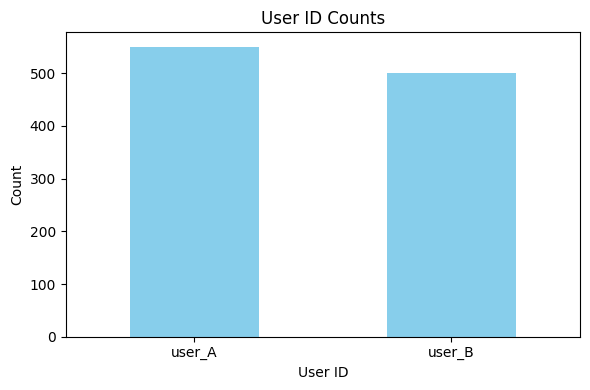

In [17]:
import matplotlib.pyplot as plt
user_counts = simulated_data['user_id'].value_counts()


plt.figure(figsize=(6, 4))
user_counts.plot(kind='bar', color='skyblue')
plt.title('User ID Counts')
plt.xlabel('User ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_564/777327025.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=simulated_data[col], ax=ax, palette='pastel')
/tmp/ipykernel_564/777327025.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=simulated_data[col], ax=ax, palette='pastel')
/tmp/ipykernel_564/777327025.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=simulated_data[col], ax=ax, palette='pastel')
/tmp/ipykernel_564/777327025.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

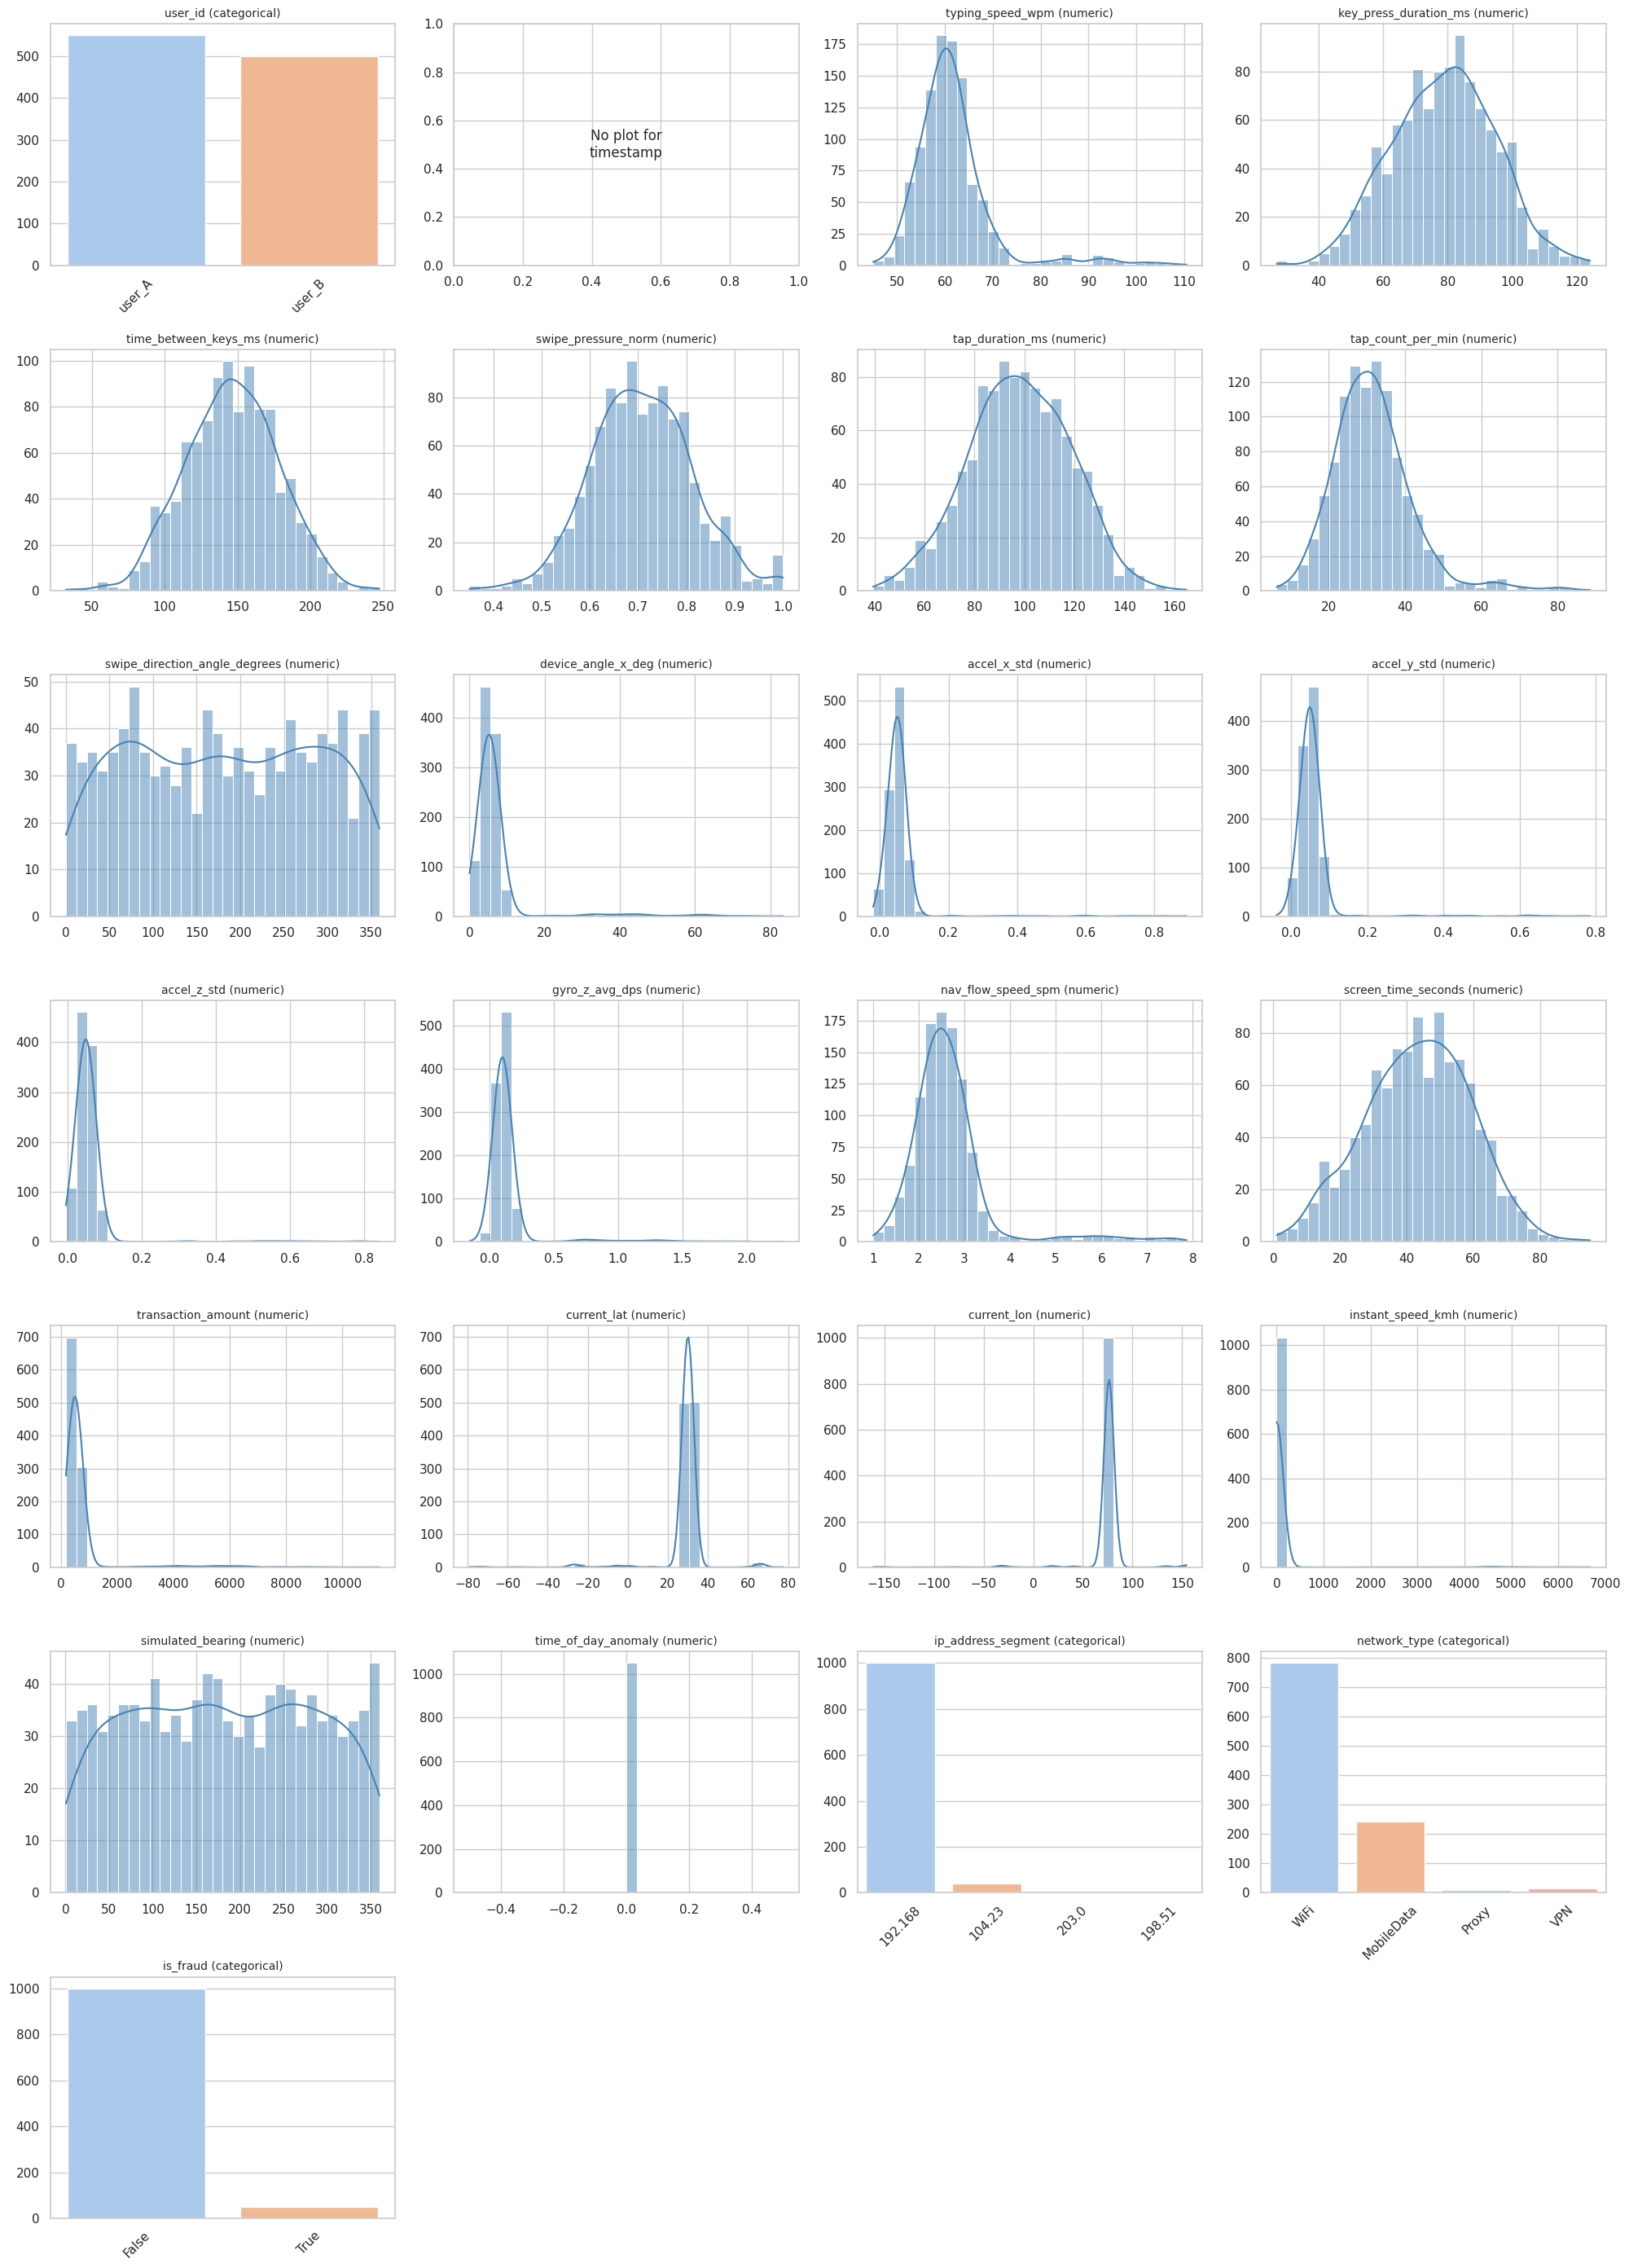

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is called `simulated_data`

# Set plot style
sns.set(style="whitegrid")

# Separate numeric and categorical columns
numeric_cols = simulated_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = simulated_data.select_dtypes(include=['object', 'bool']).columns

# Total number of plots
total_plots = len(simulated_data.columns)
cols_per_row = 4
rows = (total_plots + cols_per_row - 1) // cols_per_row

# Create subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, 4 * rows))
axes = axes.flatten()

# Plot each feature
for idx, col in enumerate(simulated_data.columns):
    ax = axes[idx]
    if col in numeric_cols:
        sns.histplot(simulated_data[col], bins=30, ax=ax, kde=True, color='steelblue')
        ax.set_title(f'{col} (numeric)', fontsize=10)
    elif col in categorical_cols:
        sns.countplot(x=simulated_data[col], ax=ax, palette='pastel')
        ax.set_title(f'{col} (categorical)', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.text(0.5, 0.5, f"No plot for\n{col}", horizontalalignment='center', verticalalignment='center')
    ax.set_xlabel("")
    ax.set_ylabel("")
user_id',
 'timestamp',
 'typing_speed_wpm',
 'key_press_duration_ms',
 'time_between_keys_ms',
 'swipe_pressure_norm',
 'tap_duration_ms',
 'tap_count_per_min',
 'swipe_direction_angle_degrees',
 'device_angle_x_deg',
 'accel_x_std',
 'accel_y_std',
 'accel_z_std',
 'gyro_z_avg_dps',
 'nav_flow_speed_spm',
 'screen_time_seconds',
 'transaction_amount',
 'current_lat',
 'current_lon',
 'instant_speed_kmh',
 'simulated_bearing',
 'time_of_day_anomaly',
 'ip_address_segment',
 'network_type',
 'is_fraud']

# Hide any unused axes
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
